<a href="https://colab.research.google.com/github/Lakshit-Bohra/Portfolio-Optimization/blob/main/Portfolio_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [466]:
from pandas_datareader import data as pdr
import yfinance as yf
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [467]:
yf.pdr_override()

In [468]:
start = datetime(2022,1,1)
end = datetime(2023,1,1)

I selected four stocks from the US nasdaq market.

In [469]:
msft = pdr.get_data_yahoo('MSFT',start,end)
google = pdr.get_data_yahoo('GOOGL',start,end)
tesla = pdr.get_data_yahoo('TSLA',start,end)
amzn = pdr.get_data_yahoo('AMZN',start,end)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [470]:
stocks = pd.concat([msft['Close'],google['Close'],tesla['Close'],amzn['Close']], axis=1)
stocks.columns = ['MICROSOFT','GOOGLE','TESLA','AMAZON']
stocks

,MICROSOFT,GOOGLE,TESLA,AMAZON
Date,,,,
2022-01-03,334.750000,144.991501,399.926666,170.404495
2022-01-04,329.010010,144.399506,383.196655,167.522003
2022-01-05,316.380005,137.774994,362.706665,164.356995
2022-01-06,313.880005,137.747498,354.899994,163.253998
2022-01-07,314.040009,137.016998,342.320007,162.554001
...,...,...,...,...
2022-12-23,238.729996,89.230003,123.150002,85.250000
2022-12-27,236.960007,87.389999,109.099998,83.040001
2022-12-28,234.529999,86.019997,112.709999,81.820000


Finding Returns of the stocks. we also need Log Returns because the prices of the stocks are in different range.

In [471]:
cov_matrix = stocks.pct_change().apply(lambda x: np.log(1+x)).cov()
cov_matrix

,MICROSOFT,GOOGLE,TESLA,AMAZON
MICROSOFT,0.000498,0.000463,0.000518,0.000525
GOOGLE,0.000463,0.000596,0.000564,0.000559
TESLA,0.000518,0.000564,0.001725,0.000769
AMAZON,0.000525,0.000559,0.000769,0.000999


In [472]:
e_r = stocks.resample('B').last().pct_change().mean()
e_r

MICROSOFT   -0.001048
GOOGLE      -0.001630
TESLA       -0.003714
AMAZON      -0.002248
dtype: float64

In [473]:
sd = stocks.pct_change().apply(lambda x: np.log(1+x)).std().apply(lambda x: x*np.sqrt(250))
sd

MICROSOFT    0.352814
GOOGLE       0.385895
TESLA        0.656611
AMAZON       0.499692
dtype: float64

In [474]:
assets = pd.concat([e_r, sd], axis=1)
assets.columns = ['Returns', 'Volatility']
assets

,Returns,Volatility
MICROSOFT,-0.001048,0.352814
GOOGLE,-0.001630,0.385895
TESLA,-0.003714,0.656611
AMAZON,-0.002248,0.499692


In [475]:
p_ret = []
p_vol = []
p_weights = []
sharpe_ratio = []

num_assets = len(stocks.columns)
num_portfolios = 1000

In [476]:
for portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights = weights/np.sum(weights)
    p_weights.append(weights)
    returns = np.dot(weights, e_r)
    p_ret.append(returns)
    var = cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()
    sd = np.sqrt(var)
    ann_sd = sd*np.sqrt(250)
    p_vol.append(ann_sd)
    SR = returns / ann_sd
    sharpe_ratio.append(SR)

In [477]:
data = {'Returns':p_ret, 'Volatility':p_vol,'Sharpe_Ratio':sharpe_ratio}

In [478]:
for counter, symbol in enumerate(stocks.columns.tolist()):
    data[symbol+' weight'] = [w[counter] for w in p_weights]

In [479]:
portfolios = pd.DataFrame(data)
portfolios.head()

,Returns,Volatility,Sharpe_Ratio,MICROSOFT weight,GOOGLE weight,TESLA weight,AMAZON weight
0,-0.002109,0.403019,-0.005232,0.316136,0.213317,0.253833,0.216715
1,-0.001839,0.389035,-0.004726,0.554539,0.015380,0.181277,0.248804
2,-0.002215,0.418490,-0.005292,0.314544,0.101403,0.277592,0.306460
3,-0.002216,0.435280,-0.005092,0.261417,0.002721,0.193604,0.542258
4,-0.001794,0.383648,-0.004676,0.219326,0.428665,0.050671,0.301339


In [480]:
portfolios[portfolios['Sharpe_Ratio']==portfolios['Sharpe_Ratio'].max()]

,Returns,Volatility,Sharpe_Ratio,MICROSOFT weight,GOOGLE weight,TESLA weight,AMAZON weight
457,-0.001353,0.358451,-0.003774,0.660343,0.181374,0.006582,0.151702


In [481]:
max_SR_port = portfolios.iloc[portfolios['Sharpe_Ratio'].idxmax()]
max_SR_port

Returns            -0.001353
Volatility          0.358451
Sharpe_Ratio       -0.003774
MICROSOFT weight    0.660343
GOOGLE weight       0.181374
TESLA weight        0.006582
AMAZON weight       0.151702
Name: 457, dtype: float64

<Figure size 1200x1200 with 0 Axes>

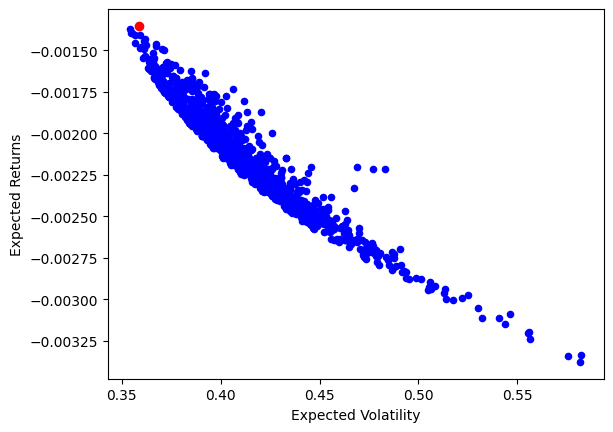

In [482]:
plt.figure(figsize=(12,12))
portfolios.plot.scatter(x='Volatility', y='Returns',c='blue')
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Returns')
plt.scatter(max_SR_port[1], max_SR_port[0], color='red')
plt.show()

In [483]:
portfolios[portfolios['Volatility']==portfolios['Volatility'].min()]

,Returns,Volatility,Sharpe_Ratio,MICROSOFT weight,GOOGLE weight,TESLA weight,AMAZON weight
416,-0.001371,0.354305,-0.00387,0.579325,0.366391,0.030754,0.023531


In [484]:
min_var_port = portfolios.iloc[portfolios['Volatility'].idxmin()]
min_var_port

Returns            -0.001371
Volatility          0.354305
Sharpe_Ratio       -0.003870
MICROSOFT weight    0.579325
GOOGLE weight       0.366391
TESLA weight        0.030754
AMAZON weight       0.023531
Name: 416, dtype: float64

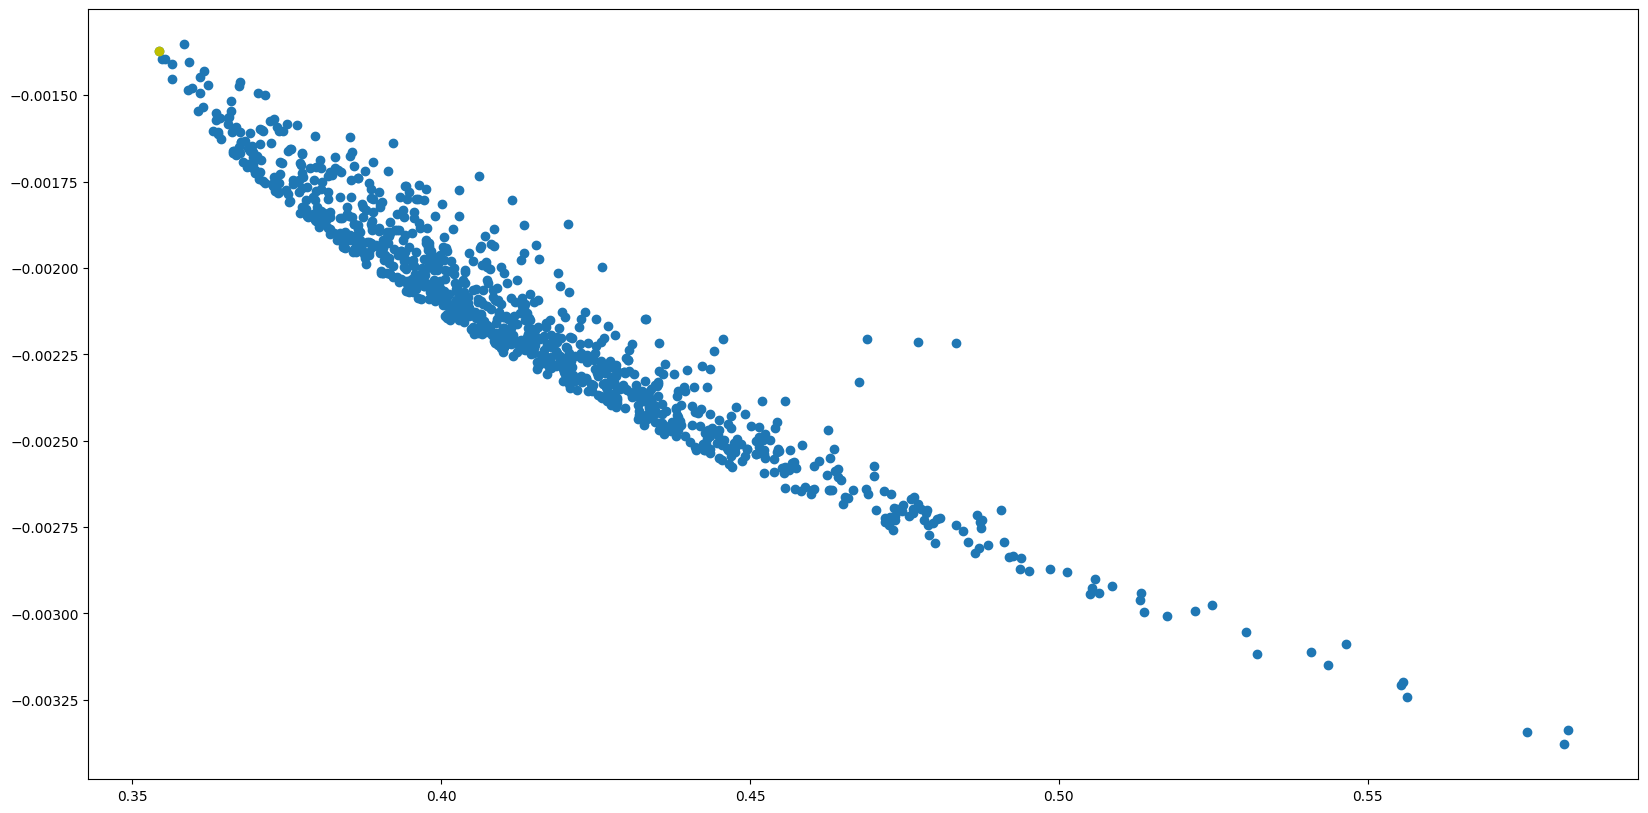

In [485]:
import matplotlib.pyplot as plt
plt.subplots(figsize=(20,10))
plt.scatter(portfolios['Volatility'], portfolios['Returns'])
plt.scatter(min_var_port[1], min_var_port[0], color='y')

Optimal Risky Portfolio

Sharpe Ratio= $ (E(R_i)-rf)/\sigma_i$

In [486]:
rf = 0.035

In [487]:
((portfolios['Returns']-rf)/portfolios['Volatility']).idxmax()

723

In [488]:
optimal_risky_port = portfolios.iloc[((portfolios['Returns']-rf)/portfolios['Volatility']).idxmax()]
optimal_risky_port

Returns            -0.003337
Volatility          0.582382
Sharpe_Ratio       -0.005729
MICROSOFT weight    0.060848
GOOGLE weight       0.060726
TESLA weight        0.818049
AMAZON weight       0.060377
Name: 723, dtype: float64

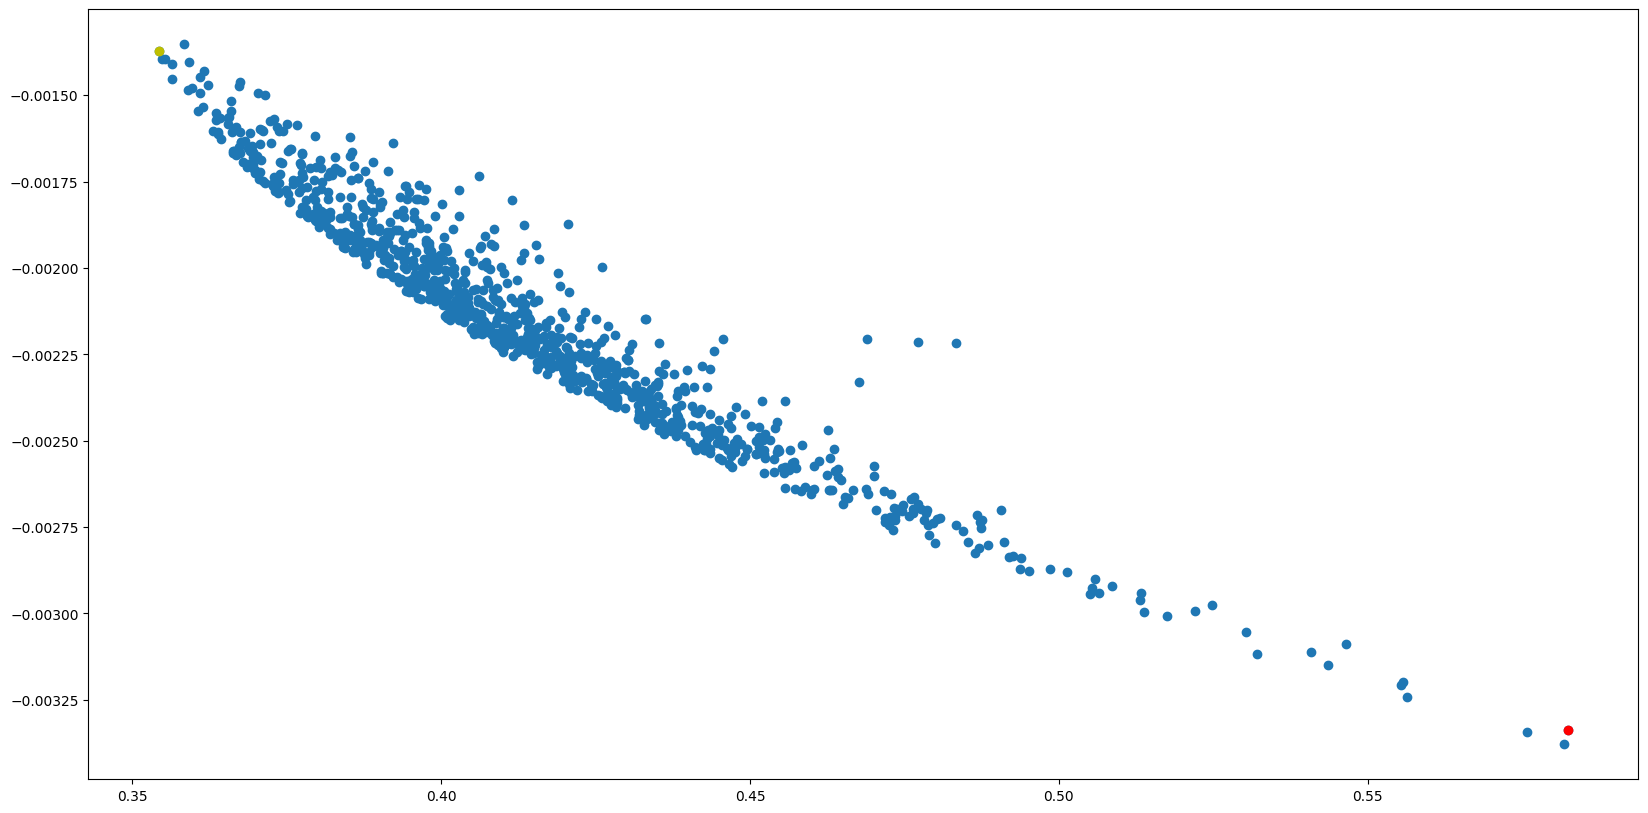

In [489]:
plt.subplots(figsize=(20,10))
plt.scatter(portfolios['Volatility'], portfolios['Returns'])
plt.scatter(min_var_port[1], min_var_port[0], color='y')
plt.scatter(optimal_risky_port[1], optimal_risky_port[0], color='red')

Utility Function

$U = E(R) - 0.5 * A * \sigma^2$

Capital Market Line

$ E(R_p) = rf + ((E(R_i) - rf)/\sigma_i)*\sigma_p $

In [490]:
cal_x = []
cal_y = []
utility = []
a = 10

In [491]:
for er in np.linspace(rf, max(p_ret), 20):
    sd = (er - rf)/((optimal_risky_port[0]-rf)/optimal_risky_port[1])
    u = er - .5*a*(sd**2)
    cal_x.append(sd)
    cal_y.append(er)
    utility.append(u)

In [492]:
data2 = {'utility':utility, 'cal_y':cal_y, 'cal_x':cal_x}
cal = pd.DataFrame(data2)
cal.head()

,utility,cal_y,cal_x
0,0.035000,0.035000,-0.000000
1,0.028863,0.033087,0.029066
2,0.014277,0.031173,0.058131
3,-0.008757,0.029260,0.087197
4,-0.040239,0.027347,0.116263


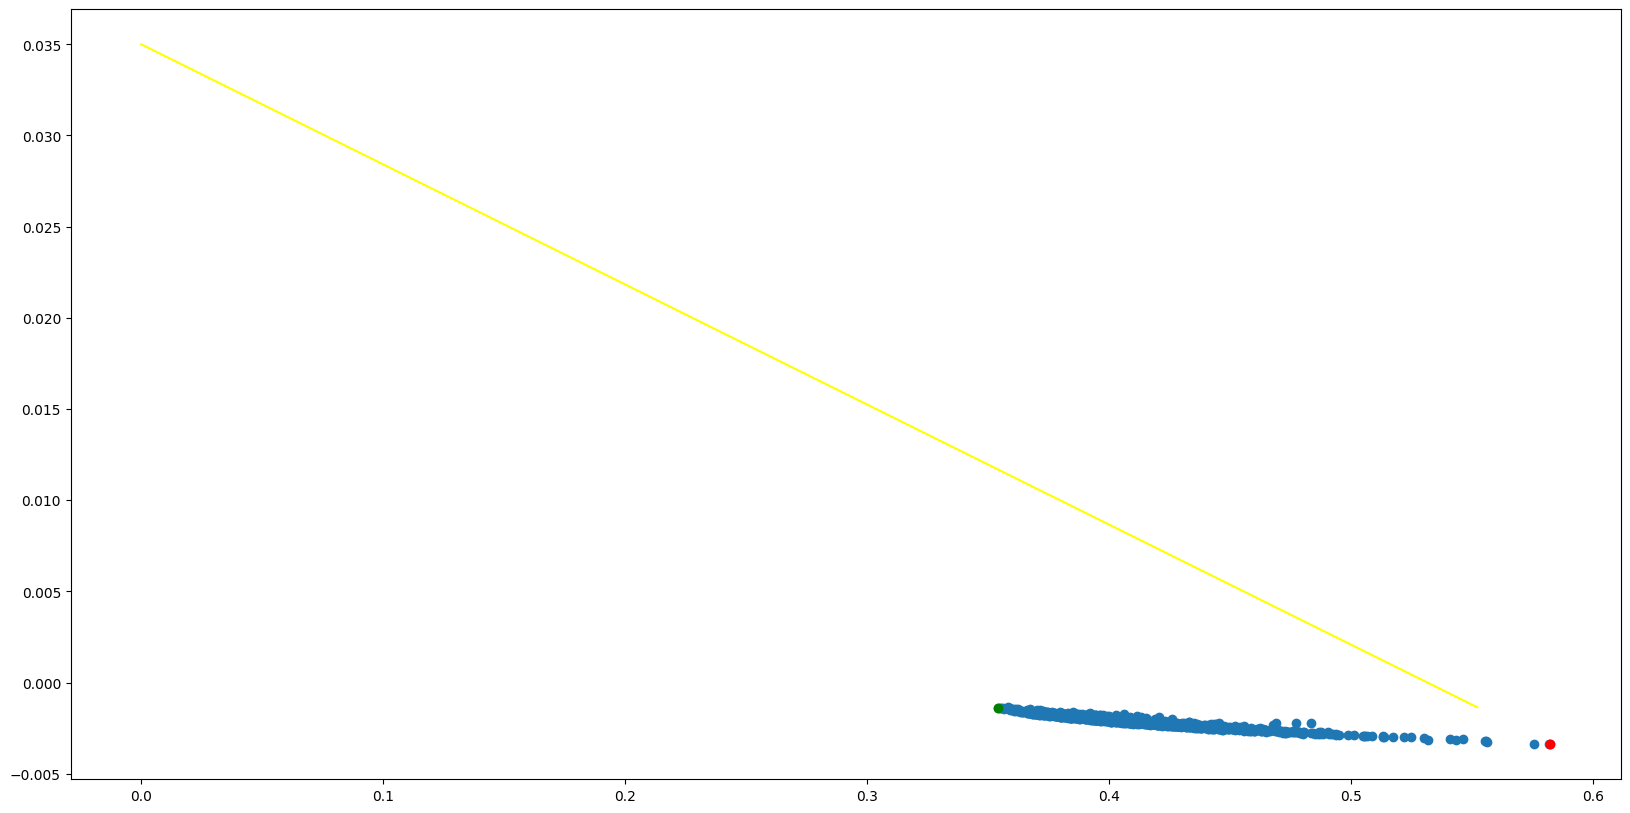

In [493]:
plt.subplots(figsize=(20,10))
plt.scatter(portfolios['Volatility'], portfolios['Returns'])
plt.scatter(min_var_port[1], min_var_port[0], color='g')
plt.scatter(optimal_risky_port[1], optimal_risky_port[0], color='red')
plt.plot(cal_x, cal_y, color='yellow')

In [494]:
cal['utility'].idxmax()

0

In [495]:
investors_port = cal.iloc[cal['utility'].idxmax()]
investors_port

utility    0.035
cal_y      0.035
cal_x     -0.000
Name: 0, dtype: float64

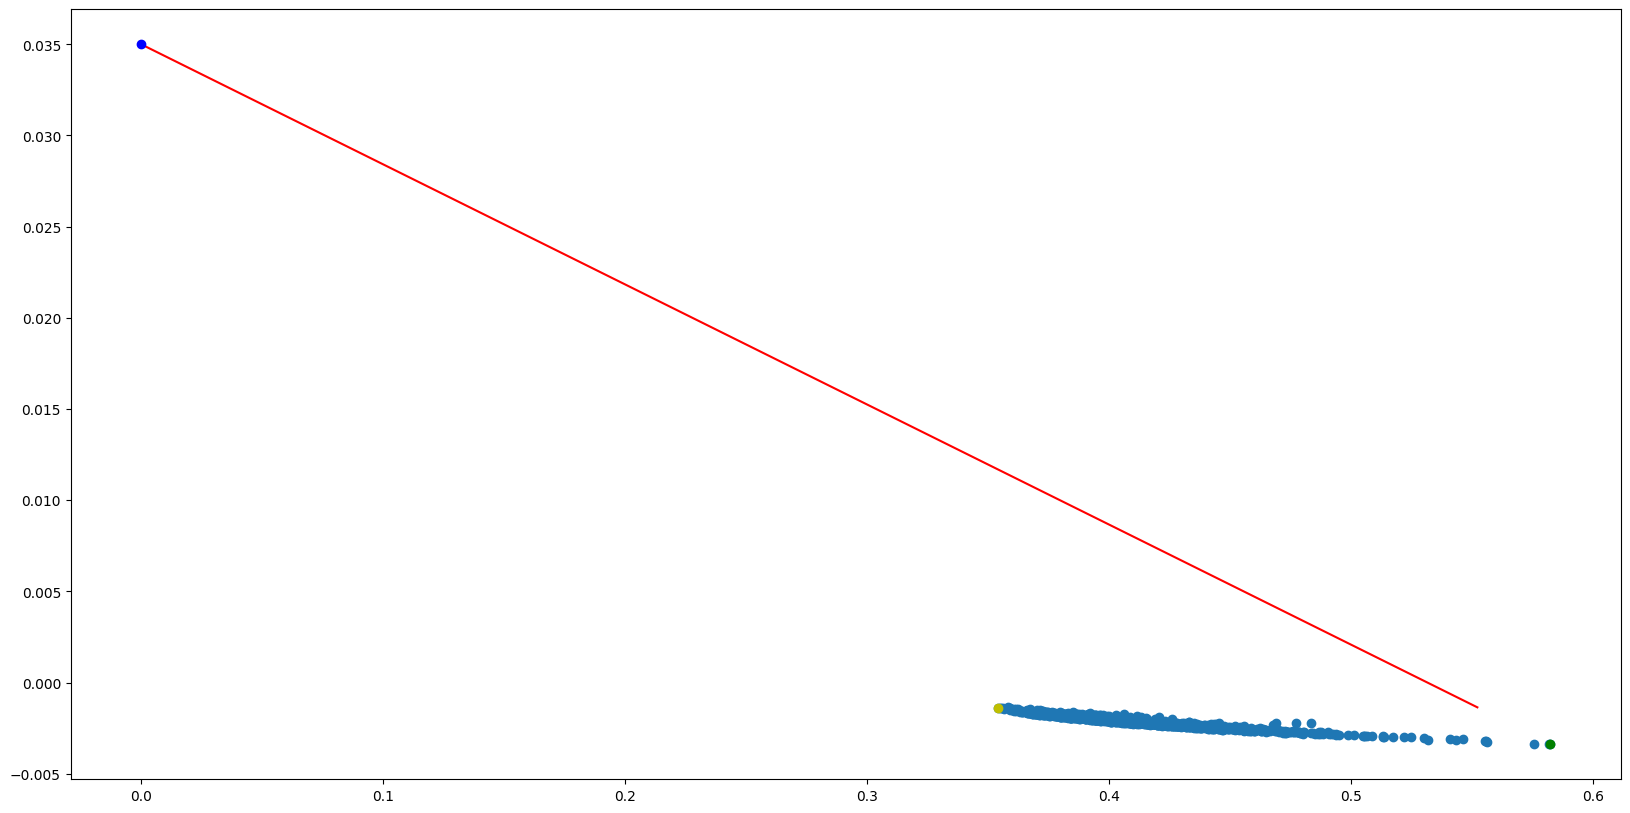

In [496]:
plt.subplots(figsize=(20,10))
plt.scatter(portfolios['Volatility'], portfolios['Returns'])
plt.scatter(min_var_port[1], min_var_port[0], color='y')
plt.scatter(optimal_risky_port[1], optimal_risky_port[0], color='g')
plt.plot(cal_x, cal_y, color='r')
plt.plot(investors_port[2], investors_port[1], 'o', color='b')